### 6610401985 นาย ไชยวัตน์ หนูวัฒนา

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### Read and Explore Data

In [2]:
eu = pd.read_csv('EURUSD_H1_csv.csv').set_index('Time').drop('Spread', axis=1)
eu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 2009-02-13 07:00:00 to 2025-02-25 07:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Open    100000 non-null  float64
 1   High    100000 non-null  float64
 2   Low     100000 non-null  float64
 3   Close   100000 non-null  float64
 4   Volume  100000 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 4.6+ MB


In [3]:
eu.head(5)

,Open,High,Low,Close,Volume
Time,,,,,
2009-02-13 07:00:00,1.29200,1.29360,1.28785,1.29315,31767
2009-02-13 08:00:00,1.29325,1.29380,1.28910,1.29065,29255
2009-02-13 09:00:00,1.29065,1.29250,1.28890,1.28955,35931
2009-02-13 10:00:00,1.28955,1.29120,1.28785,1.28955,31326
2009-02-13 11:00:00,1.28955,1.28965,1.28525,1.28540,28001


In [4]:
eu.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

### Label the data

In [5]:
eu['isBullish'] = eu.Close > eu.Open
eu['next_bars_bullish'] = eu['isBullish'].shift(-1)
eu['next_bars_bullish'] = eu['next_bars_bullish'].map({True: 'Bullish', False: 'Bearish'})

eu.head(5)

,Open,High,Low,Close,Volume,isBullish,next_bars_bullish
Time,,,,,,,
2009-02-13 07:00:00,1.29200,1.29360,1.28785,1.29315,31767,True,Bearish
2009-02-13 08:00:00,1.29325,1.29380,1.28910,1.29065,29255,False,Bearish
2009-02-13 09:00:00,1.29065,1.29250,1.28890,1.28955,35931,False,Bearish
2009-02-13 10:00:00,1.28955,1.29120,1.28785,1.28955,31326,False,Bearish
2009-02-13 11:00:00,1.28955,1.28965,1.28525,1.28540,28001,False,Bearish


In [6]:
eu = eu.dropna()

### Feature Engineering

Since I will not classify direction base on candle's price directly so I will do the feature engineering to tranform raw candle's price into financial metrics and indicators

In [7]:
def compute_financial_metrics(df):
    df['price_change'] = df['Close'] - df['Close'].shift(1)
    df['price_change_percentage'] = df['price_change'] / df['Close'].shift(1) * 100

    df['candle_range'] = df['High'] - df['Low']
    df['volatility'] = df['price_change'].rolling(10).std()
    df['momentum'] = df['Close'] - df['Open'].shift(10)
    df = df.drop(columns='price_change')
    
    df['rolling_mean_volume'] = df['Volume'].rolling(10).mean()
    df['rolling_mean_volatility'] = df['volatility'].rolling(10).mean()
    df['rolling_mean_momentum'] = df['momentum'].rolling(10).mean()
    return df


In [8]:
def compute_indicators(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    for n in [5, 12, 26, 10, 20, 50]:
        df[f'SMA_{n}'] = df['Close'].rolling(window=n).mean()
        df[f'EMA_{n}'] = df['Close'].ewm(span=n, adjust=False).mean()
    
    df['bollinger_mid'] = df['Close'].rolling(window=20).mean()
    df['bollinger_std'] = df['Close'].rolling(window=20).std()
    df['bollinger_upper'] = df['bollinger_mid'] + 2 * df['bollinger_std']
    df['bollinger_lower'] = df['bollinger_mid'] - 2 * df['bollinger_std']
    
    for n in [5, 10, 20]:
        df[f'volume_SMA_{n}'] = df['Volume'].rolling(window=n).mean()
        df[f'volume_EMA_{n}'] = df['Volume'].ewm(span=n, adjust=False).mean()
    
    df['VPT'] = (df['Close'].pct_change() * df['Volume']).cumsum()
    
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df = df.drop(columns=['SMA_12', 'SMA_26', 'EMA_12', 'EMA_26'])
    
    df['14stoch_k'] = ((df['Close'] - df['Low'].rolling(14).min()) / 
                      (df['High'].rolling(14).max() - df['Low'].rolling(14).min())) * 100
    df['55stoch_k'] = ((df['Close'] - df['Low'].rolling(55).min()) / 
                      (df['High'].rolling(55).max() - df['Low'].rolling(55).min())) * 100
    
    df['hour'] = df.index.hour
    
    df['cum_volume'] = df['Volume'].cumsum()
    df['cum_vwap'] = (df['Close'] * df['Volume']).cumsum() / df['cum_volume']
    
    df.drop(columns=['cum_volume'], inplace=True)
    
    return df

In [9]:
df = compute_financial_metrics(eu)
df = compute_indicators(df)

df.drop(columns=['Open', 'High', 'Low', 'Close'], inplace=True)
df.dropna(inplace=True)

In [10]:
df.shape

(99945, 35)

| **Feature** | **คำอธิบาย** |
|------------|-------------|
| `price_change_percentage` | เปอร์เซ็นต์การเปลี่ยนแปลงของราคาปิดเทียบกับแท่งก่อนหน้า |
| `candle_range` | ช่วงระยะห่างระหว่างราคาสูงสุด (`High`) และราคาต่ำสุด (`Low`) ของแท่งเทียน |
| `volatility` | ส่วนเบี่ยงเบนมาตรฐานของ `price_change_percentage` ในช่วง 10 แท่ง เพื่อวัดความผันผวน |
| `momentum` | ส่วนต่างระหว่างราคาปิดปัจจุบันและราคาเปิดเมื่อ 10 แท่งที่แล้ว |
| `rolling_mean_volume` | ค่าเฉลี่ยของปริมาณการซื้อขาย (`Volume`) ในช่วง 10 แท่ง |
| `rolling_mean_volatility` | ค่าเฉลี่ยของความผันผวน (`volatility`) ในช่วง 10 แท่ง |
| `SMA_n` (n = 5, 10, 12, 20, 26, 50) | ค่าเฉลี่ยเคลื่อนที่แบบเส้นตรง (Simple Moving Average) ของราคาปิดในช่วง `n` แท่ง |
| `EMA_n` (n = 5, 10, 12, 20, 26, 50) | ค่าเฉลี่ยเคลื่อนที่แบบ Exponential (Exponential Moving Average) ของราคาปิดในช่วง `n` แท่ง |
| `bollinger_mid` | ค่าเฉลี่ยเคลื่อนที่ของราคาปิดในช่วง 20 แท่ง (เส้นกลางของ Bollinger Bands) |
| `bollinger_std` | ส่วนเบี่ยงเบนมาตรฐานของราคาปิดในช่วง 20 แท่ง |
| `bollinger_upper` | เส้นบนของ Bollinger Bands (`bollinger_mid + 2 * bollinger_std`) |
| `bollinger_lower` | เส้นล่างของ Bollinger Bands (`bollinger_mid - 2 * bollinger_std`) |
| `volume_SMA_n` (n = 5, 10, 20) | ค่าเฉลี่ยเคลื่อนที่แบบเส้นตรงของ Volume ในช่วง `n` แท่ง |
| `volume_EMA_n` (n = 5, 10, 20) | ค่าเฉลี่ยเคลื่อนที่แบบ Exponential ของ Volume ในช่วง `n` แท่ง |
| `VPT` (Volume Price Trend) | ตัวชี้วัดที่สะสมการเปลี่ยนแปลงของราคา (`Close.pct_change()`) คูณกับ Volume |
| `MACD` | ค่าความแตกต่างระหว่าง `EMA_12` และ `EMA_26` (ใช้วิเคราะห์แนวโน้มของราคา) |
| `MACD_signal` | ค่า `MACD` ที่ถูกทำให้เรียบขึ้นด้วย `EMA_9` (ใช้เป็นเส้นสัญญาณ) |
| `14stoch_k` | Stochastic %K ระยะ 14 แท่ง (ใช้ดูว่า RSI อยู่ในโซน Overbought หรือ Oversold) |
| `55stoch_k` | Stochastic %K ระยะ 55 แท่ง (ดูแนวโน้มในระยะยาวขึ้น) |
| `hour` | ชั่วโมงของแต่ละแท่งเทียน (อาจช่วยในการวิเคราะห์พฤติกรรมของตลาดในช่วงเวลาต่างๆ) |
| `cum_vwap` | ค่าเฉลี่ยราคาถ่วงน้ำหนักตามปริมาณการซื้อขาย (VWAP) แบบสะสม |
| `rolling_mean_momentum` | ค่าเฉลี่ยเคลื่อนที่ของ `momentum` ในช่วง 10 แท่ง (ดูแนวโน้มของโมเมนตัม) |

---


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99945 entries, 2009-02-17 13:00:00 to 2025-02-25 06:00:00
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Volume                   99945 non-null  int64  
 1   isBullish                99945 non-null  bool   
 2   next_bars_bullish        99945 non-null  object 
 3   price_change_percentage  99945 non-null  float64
 4   candle_range             99945 non-null  float64
 5   volatility               99945 non-null  float64
 6   momentum                 99945 non-null  float64
 7   rolling_mean_volume      99945 non-null  float64
 8   rolling_mean_volatility  99945 non-null  float64
 9   rolling_mean_momentum    99945 non-null  float64
 10  SMA_5                    99945 non-null  float64
 11  EMA_5                    99945 non-null  float64
 12  SMA_10                   99945 non-null  float64
 13  EMA_10                   99945 non-null  

### Modelling

#### Decision Tree

A Decision Tree is a tree-based model that uses impurity functions (e.g., Gini, Entropy) to select the most relevant features for classification. Since the dataset has around 40 features, a tree-based algorithm is a good choice for modeling.

In [12]:
from sklearn.tree import DecisionTreeClassifier

#### Random Forest

Random Forest is an algorithm that applies the Bagging technique to Decision Trees. When working with high-dimensional data, tree-based models are useful because they use impurity functions (e.g., Gini Impurity, Entropy) to select the most important features. However, a single Decision Tree often overfits the training data due to high variance. By combining multiple trees using Bagging, Random Forest reduces variance and improves generalization.

In [13]:
from sklearn.ensemble import RandomForestClassifier

#### Support Vector Machine (SVM)

Support Vector Machine (SVM) works by finding the optimal hyperplane to separate the data. The hyperplane is chosen to maximize the margin between the closest points of the two classes. I will compare SVM to Random Forest. First, I will use Random Forest for feature selection and then train SVM with the most important features. Since some data may not be perfectly separated by a straight line, I will use Kernel Trick to transform the data into a higher-dimensional space, making it easier to find a good decision boundary. I will try different kernels, such as RBF and Polynomial, to see which one works best.

In [14]:
from sklearn.svm import SVC

### Model Selection

In [15]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def plot_learning_curve(model, X, y, model_name, ax, baseline=0.5):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    ax.plot(train_sizes, train_mean, label="Training Accuracy", marker="o")
    ax.plot(train_sizes, val_mean, label="Validation Accuracy", marker="o")
    ax.axhline(y=baseline, color="r", linestyle="--", label="Baseline (50%)")
    ax.set_xlabel("Training Set Size")
    ax.set_ylabel("Accuracy")
    ax.set_title(model_name)
    ax.legend()
    ax.grid()

In [16]:
X = df.drop(columns=['next_bars_bullish'])
y = df['next_bars_bullish']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

##### Baseline

Since the dataset has a roughly equal ratio of Bullish and Bearish labels (~50%), a random guess would achieve 50% accuracy. Therefore, I will use 50% accuracy as the baseline for evaluating model performance.

In [17]:
df.next_bars_bullish.value_counts() / len(df)

next_bars_bullish
Bearish    0.500355
Bullish    0.499645
Name: count, dtype: float64

#### Decision Tree

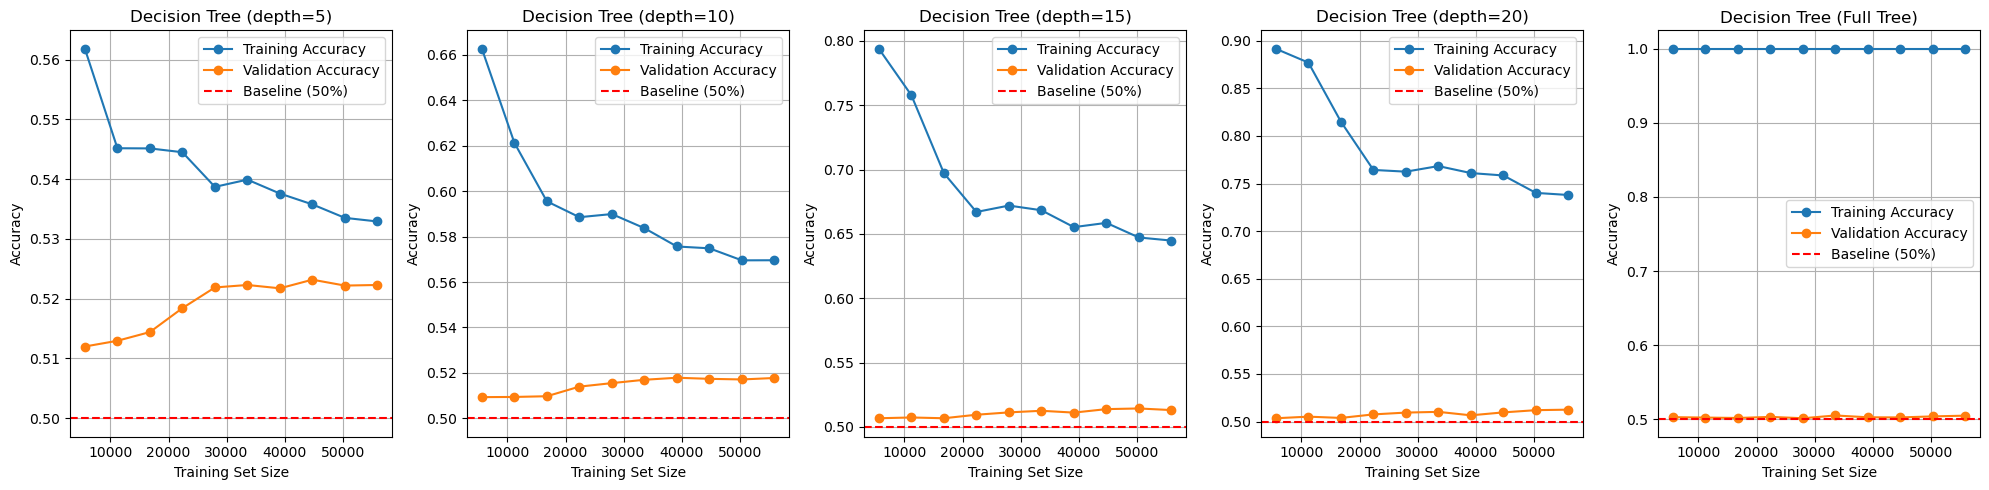

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, depth in enumerate([5, 10, 15, 20], start=0):
    dt = DecisionTreeClassifier(max_depth=depth)
    plot_learning_curve(dt, X_train, y_train, f"Decision Tree (depth={depth})", axes[i])
dt = DecisionTreeClassifier()
plot_learning_curve(dt, X_train, y_train, "Decision Tree (Full Tree)", axes[4])

plt.tight_layout()
plt.show()

In [19]:
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [20]:
y_pred = dt.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

     Bearish       0.52      0.55      0.53     15049
     Bullish       0.52      0.49      0.50     14935

    accuracy                           0.52     29984
   macro avg       0.52      0.52      0.52     29984
weighted avg       0.52      0.52      0.52     29984



From the learning curves above, we can observe that all Decision Trees, regardless of depth, exhibit the same pattern: high training accuracy but low validation accuracy. This behavior indicates high variance (overfitting). To mitigate this issue, I will apply Bagging techniques, such as Random Forest, to reduce variance and improve generalization.

#### Random Forest (Bagged Decision Tree)

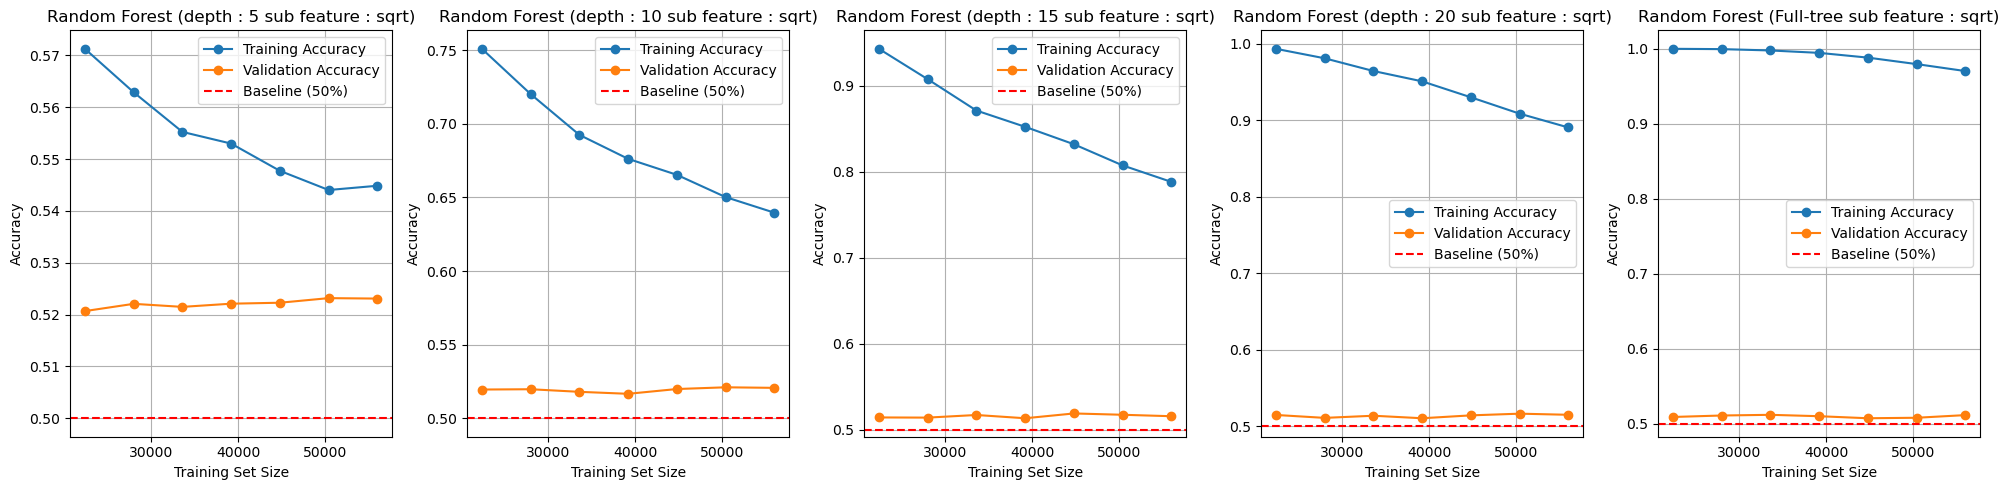

In [22]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, depth in enumerate([5, 10, 15, 20], start=0):
    rf = RandomForestClassifier(n_estimators=50, max_samples=20000,max_depth=depth,max_features="sqrt", bootstrap=True, n_jobs=-1)
    plot_learning_curve(rf, X_train, y_train, f'Random Forest (depth : {depth} sub feature : sqrt)', axes[i])
rf = RandomForestClassifier(n_estimators=50, max_samples=20000, max_features="sqrt", bootstrap=True, n_jobs=-1)
plot_learning_curve(rf, X_train, y_train, f'Random Forest (Full-tree sub feature : sqrt)', axes[4])

plt.tight_layout()
plt.show()

In [23]:
rf = RandomForestClassifier(n_estimators=50, max_samples=20000,max_depth=10,max_features="sqrt", bootstrap=True, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_samples=20000, n_estimators=50,
                       n_jobs=-1)

In [24]:
y_pred = rf.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

     Bearish       0.52      0.52      0.52     15049
     Bullish       0.52      0.52      0.52     14935

    accuracy                           0.52     29984
   macro avg       0.52      0.52      0.52     29984
weighted avg       0.52      0.52      0.52     29984



From the learning curves above, we can see that all Random Forest models, regardless of depth, still show the same pattern: high training accuracy but low validation accuracy. While Random Forest helps reduce variance compared to a single Decision Tree (Very Slightly), the overfitting issue remains when the depth of tree is high. To further address this, we can consider using boosting techniques on the low depth tree and see the results.

#### AdaBoost

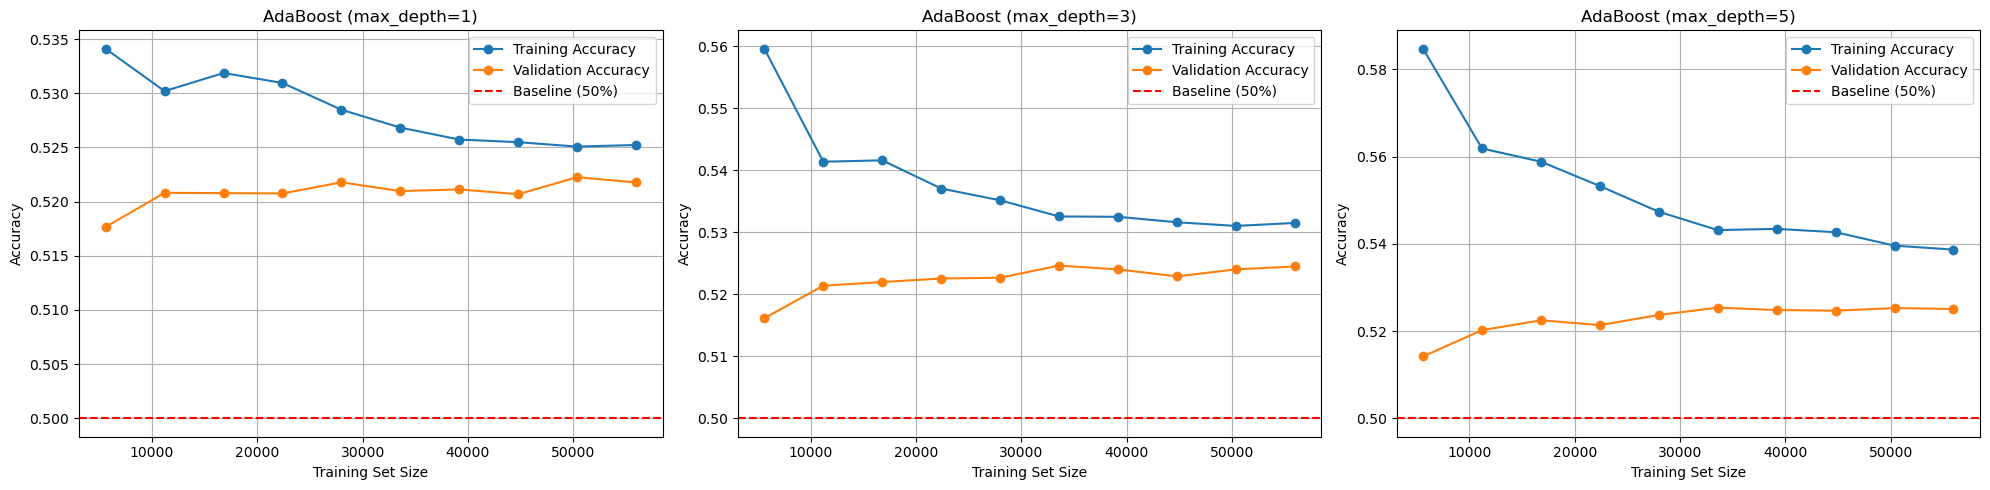

In [26]:
from sklearn.ensemble import AdaBoostClassifier

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, depth in enumerate([1, 3, 5], start=0):
    base_learner = DecisionTreeClassifier(max_depth=depth)
    ada = AdaBoostClassifier(base_learner, algorithm="SAMME", n_estimators=50, learning_rate=0.1, random_state=42)
    plot_learning_curve(ada, X_train, y_train, f'AdaBoost (max_depth={depth})', axes[i])

plt.tight_layout()
plt.show()

In [27]:
base_learner = DecisionTreeClassifier(max_depth=5)
ada = AdaBoostClassifier(base_learner, algorithm="SAMME", n_estimators=100, learning_rate=0.1, random_state=42)
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.1, n_estimators=100, random_state=42)

In [28]:
y_pred = ada.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

     Bearish       0.53      0.51      0.52     15049
     Bullish       0.52      0.54      0.53     14935

    accuracy                           0.53     29984
   macro avg       0.53      0.53      0.53     29984
weighted avg       0.53      0.53      0.53     29984



From the learning curves above, we can see that even with Boosting (AdaBoost) applied to stump trees, the improvement is very minimal. Next, we will use Support Vector Machine (SVM) to create a linear decision boundary instead of relying on tree-based models, and see the results.

#### Support Vector Machine

Since there are many features, we will perform feature selection by analyzing feature importance from the tree-based models we experimented with. The selected features will then be used in Support Vector Machine (SVM).

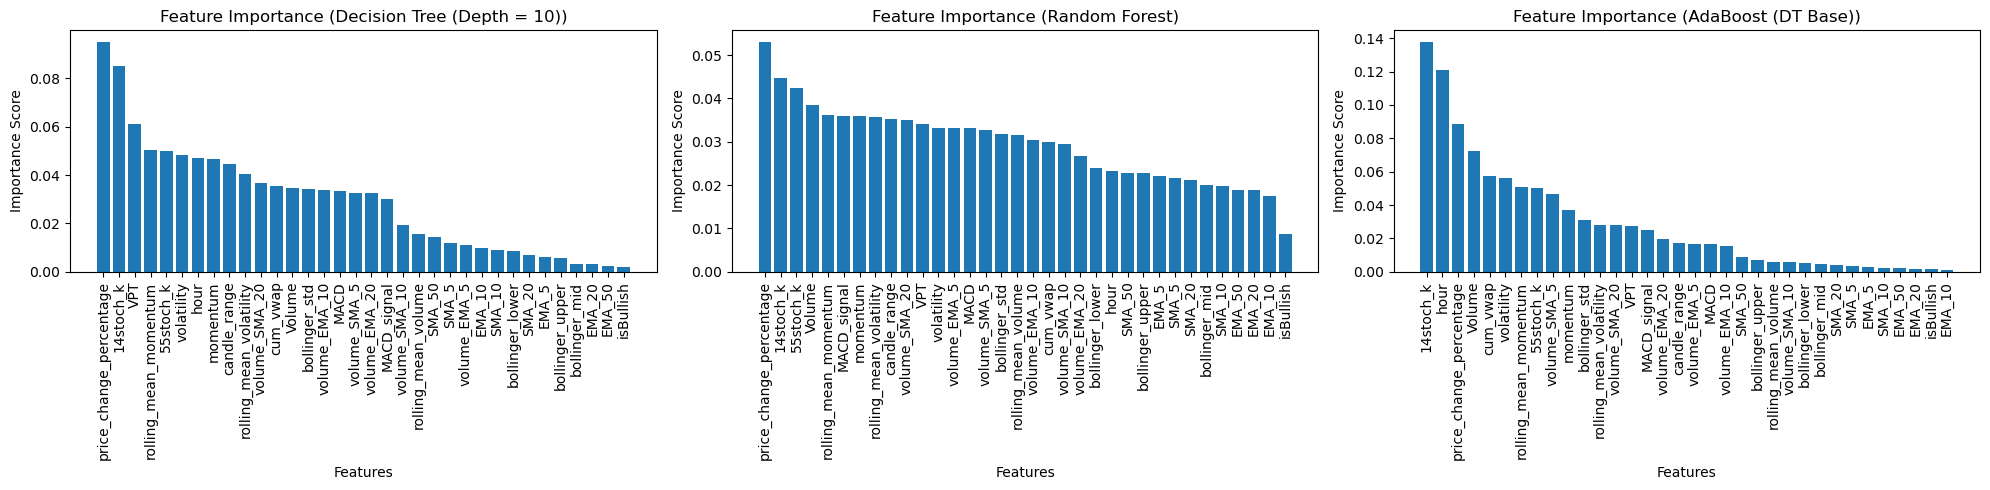

In [30]:
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.title("Feature Importance (Decision Tree (Depth = 10))")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.subplot(1, 3, 2)
plt.title("Feature Importance (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")

importances = ada.feature_importances_

indices = np.argsort(importances)[::-1]

plt.subplot(1, 3, 3)
plt.title("Feature Importance (AdaBoost (DT Base))")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")

plt.tight_layout()
plt.show()

In [31]:
feature_set = set()

top_feature = 6

for model in [dt, rf, ada] :
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    for feature in list(X_train.columns[indices][:top_feature]):
        feature_set.add(feature)

feature_set

{'14stoch_k',
 '55stoch_k',
 'MACD_signal',
 'VPT',
 'Volume',
 'cum_vwap',
 'hour',
 'price_change_percentage',
 'rolling_mean_momentum',
 'volatility'}

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [33]:
scaler = StandardScaler()

X_train_selected_scaled = scaler.fit_transform(X_train[list(feature_set)])
X_test_selected_scaled = scaler.fit_transform(X_test[list(feature_set)])

#### Linear Kernel SVM

In [46]:
svc = SVC(C=0.00001, kernel='linear')

svc.fit(X_train_selected_scaled, y_train)

SVC(C=1e-05, kernel='linear')

In [47]:
y_pred = svc.predict(X_test_selected_scaled)

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

     Bearish       0.00      0.00      0.00     15049
     Bullish       0.50      1.00      0.66     14935

    accuracy                           0.50     29984
   macro avg       0.25      0.50      0.33     29984
weighted avg       0.25      0.50      0.33     29984



In [40]:
svc = SVC(C=0.001, kernel='linear')

svc.fit(X_train_selected_scaled, y_train)

SVC(C=0.001, kernel='linear')

In [41]:
y_pred = svc.predict(X_test_selected_scaled)

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

     Bearish       0.52      0.52      0.52     15049
     Bullish       0.52      0.52      0.52     14935

    accuracy                           0.52     29984
   macro avg       0.52      0.52      0.52     29984
weighted avg       0.52      0.52      0.52     29984



In [38]:
svc = SVC(C=0.01, kernel='linear')

svc.fit(X_train_selected_scaled, y_train)

SVC(C=0.01, kernel='linear')

In [39]:
y_pred = svc.predict(X_test_selected_scaled)

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

     Bearish       0.52      0.52      0.52     15049
     Bullish       0.52      0.52      0.52     14935

    accuracy                           0.52     29984
   macro avg       0.52      0.52      0.52     29984
weighted avg       0.52      0.52      0.52     29984



In [42]:
svc = SVC(C=1, kernel='linear')

svc.fit(X_train_selected_scaled, y_train)

SVC(C=1, kernel='linear')

In [43]:
y_pred = svc.predict(X_test_selected_scaled)

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

     Bearish       0.52      0.52      0.52     15049
     Bullish       0.52      0.52      0.52     14935

    accuracy                           0.52     29984
   macro avg       0.52      0.52      0.52     29984
weighted avg       0.52      0.52      0.52     29984



#### RBF Kernel SVM

Optimal C Value: 1.0000


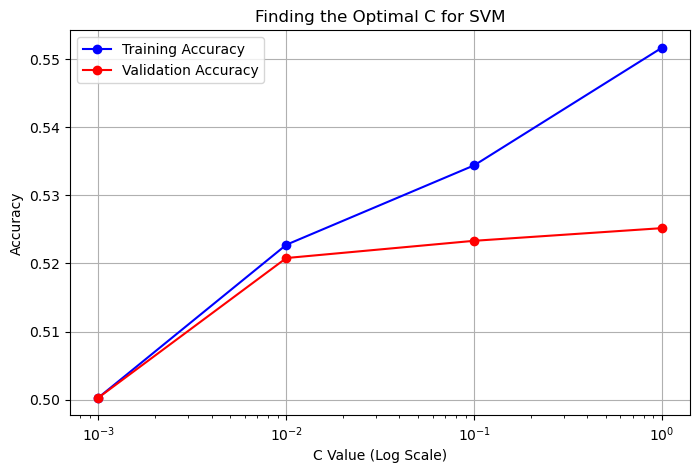

In [34]:
C_values = [0.001, 0.01, 0.1, 1]
train_scores = []
val_scores = []

# วนลูปทดสอบค่า C
for C in C_values:
    svm = SVC(C=C, kernel='rbf')
    
    train_sizes, train_score, val_score = learning_curve(
        svm, X_train_selected_scaled, y_train, cv=5, scoring="accuracy", train_sizes=[1.0], n_jobs=-1
    )

    train_scores.append(train_score.mean())
    val_scores.append(val_score.mean())

# หา C ที่ดีที่สุด
best_C = C_values[np.argmax(val_scores)]
print(f"Optimal C Value: {best_C:.4f}")

# Plot กราฟ
plt.figure(figsize=(8, 5))
plt.plot(C_values, train_scores, marker='o', linestyle='-', label="Training Accuracy", color='blue')
plt.plot(C_values, val_scores, marker='o', linestyle='-', label="Validation Accuracy", color='red')

plt.xscale("log")
plt.xlabel("C Value (Log Scale)")
plt.ylabel("Accuracy")
plt.title("Finding the Optimal C for SVM")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
svm = SVC(C=best_C, kernel='rbf')
svm.fit(X_train_selected_scaled, y_train)

y_pred = svm.predict(X_test_selected_scaled)
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

     Bearish       0.53      0.54      0.53     15049
     Bullish       0.53      0.51      0.52     14935

    accuracy                           0.53     29984
   macro avg       0.53      0.53      0.53     29984
weighted avg       0.53      0.53      0.53     29984

